In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import h5py as h5

In [2]:
file = h5.File('../output/large/lcdm.h5')
# file.close()

In [3]:
p = file["potential"][:]

In [4]:
p.min()

-205.37240680873484

In [5]:
p.max()

185.92400933866242

In [4]:
file.close()

In [5]:
def polygon_to_triangles(p):
    return np.c_[np.repeat(p[0], p.size - 2), p[1:-1], p[2:]]

class Mesh:
    def __init__(self, h5_group):
        """Initialize a mesh from a group in a HDF5 file."""
        self.vertices = h5_group['vertices'][:].astype('float64')
        data = h5_group['data'][:]
        sizes = h5_group['sizes'][:]
        self.info = h5_group['info'][:].astype('float64')
        i1 = np.cumsum(sizes)
        i0 = np.r_[[0], i1[:-1]].astype(np.uint)
        self.polygons = [data[i:j] for i, j in np.c_[i0, i1]]
    
    @property
    def triangles(self):
        return np.concatenate([polygon_to_triangles(p) for p in self.polygons])

In [3]:
nodes = [file[str(s)]["nodes"][:] for s in range(3)]

In [110]:
from scipy.optimize import least_squares

def lognormal(A, mu, sigma):
    def f(x):
        y = np.log(x / mu)
        return A * np.exp(-y**2 / (2 * sigma**2))
    
    return f

def schechter(A, x_star, gamma):
    def f(x):
        y = x / x_star
        return A * y**gamma * np.exp(-y)
    
    return f

def q(pars, f, x, y):
    return f(*pars)(x) - y

/home/johannes/.local/share/workon/cosmology/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


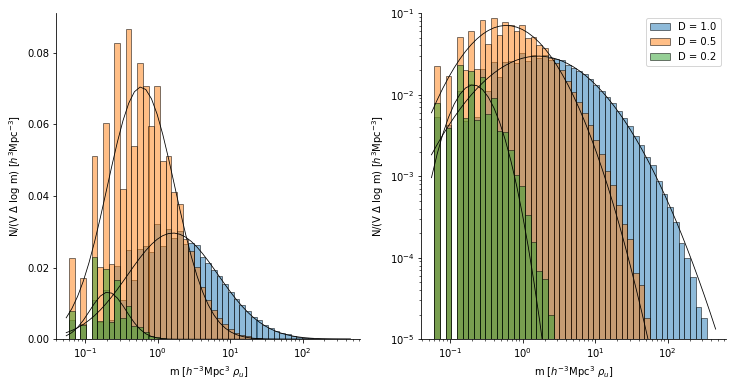

In [126]:
bins = np.logspace(-1.3, 2.7, 52)
bin_width = bins[1:] - bins[:-1]
logbin_width = np.log(bins[1:] / bins[:-1])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[1].set_yscale("log")

for ax in axes:
    ax.set_xscale("log")

    x = np.sqrt(bins[:-1]) * np.sqrt(bins[1:])
    t = [0.2, 0.5, 1.0]
    for i in range(3)[::-1]:
        m = nodes[i][np.where(nodes[i]['node_type'] == 4)]['mass']
        hist = np.histogram(m, bins=bins)
        y = hist[0] / logbin_width / 150.0**3
        fit = least_squares(q, np.ones(3), args=(lognormal, x, y))
        ax.bar(x, y, width=bin_width,
               label="D = {}".format(t[i]), alpha=0.5, edgecolor='k')
        ax.plot(x, lognormal(*fit.x)(x), c='k', lw=0.8)
        # ax.plot(x, y, c='k')

    ax.set_xlim(10**-1.4, 10**2.8)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xlabel("m [$h^{-3}{\\rm Mpc}^3\\ \\rho_u$]")
    ax.set_ylabel("N/(V $\Delta$ log m) [$h^3{\\rm Mpc}^{-3}$]")

axes[1].legend()
axes[1].set_ylim(1e-5, 1e-1)
fig.savefig('mass-functions.svg', bbox_inches='tight')